In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from math import sqrt, floor, ceil
from PIL import Image
import math

Image size is: (256, 256, 3)
Smalled Image size is: (64, 64, 3)


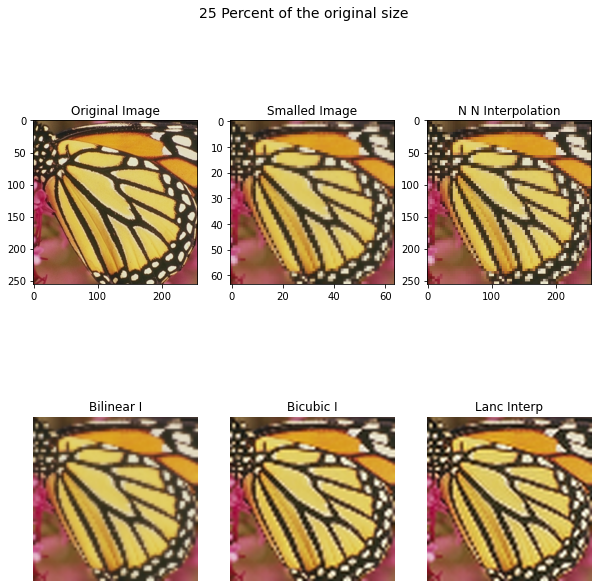

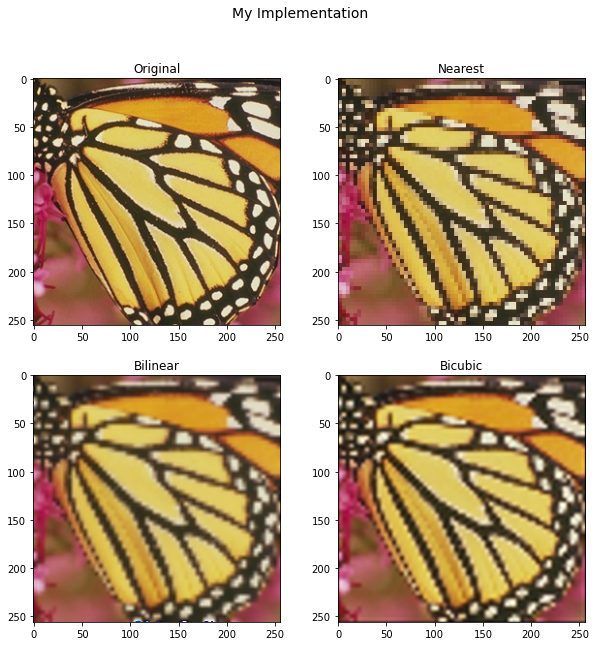

In [2]:
def read_image(path):
    '''Read image and return the image propertis.
    Parameters:
    path (string): Image path

    Returns:
    numpy.ndarray: Image exists in "path"
    list: Image size
    tuple: Image dimension (number of rows and columns)
    '''
    img = cv2.imread(path)  # cv2.IMREAD_GRAYSCALE
    size = img.shape
    dimension = (size[0], size[1])

    return img, size, dimension


def image_change_scale(img, dimension, scale=100, interpolation=cv2.INTER_LINEAR):
    '''Resize image to a specificall scale of original image.
    Parameters:
    img (numpy.ndarray): Original image
    dimension (tuple): Original image dimension
    scale (int): Multiply the size of the original image

    Returns:
    numpy.ndarray: Resized image
    '''
    scale /= 100
    new_dimension = (int(dimension[1]*scale), int(dimension[0]*scale))
    resized_img = cv2.resize(img, new_dimension, interpolation=interpolation)

    return resized_img

#__________________________________________________________________________________________________________________
def nearest_interpolation(image, dimension):
    '''Nearest neighbor interpolation method to convert small image to original image
    Parameters:
    img (numpy.ndarray): Small image
    dimension (tuple): resizing image dimension

    Returns:
    numpy.ndarray: Resized image
    '''
    new_image = np.zeros((dimension[0], dimension[1], image.shape[2]))

    enlarge_time = int(
        sqrt((dimension[0] * dimension[1]) / (image.shape[0]*image.shape[1])))

    for i in range(dimension[0]):
        for j in range(dimension[1]):
            row = floor(i / enlarge_time)
            column = floor(j / enlarge_time)

            new_image[i, j] = image[row, column]

    return new_image
#______________________________________________________________________________________________________________

def bilinear_interpolation(image, dimension):
    '''Bilinear interpolation method to convert small image to original image
    Parameters:
    img (numpy.ndarray): Small image
    dimension (tuple): resizing image dimension

    Returns:
    numpy.ndarray: Resized image
    '''
    height = image.shape[0]
    width = image.shape[1]

    scale_x = (width)/(dimension[1])
    scale_y = (height)/(dimension[0])

    new_image = np.zeros((dimension[0], dimension[1], image.shape[2]))

    for k in range(3):
        for i in range(dimension[0]):
            for j in range(dimension[1]):
                x = (j+0.5) * (scale_x) - 0.5
                y = (i+0.5) * (scale_y) - 0.5

                x_int = int(x)
                y_int = int(y)

                # Prevent crossing
                x_int = min(x_int, width-2)
                y_int = min(y_int, height-2)

                x_diff = x - x_int
                y_diff = y - y_int

                a = image[y_int, x_int, k]
                b = image[y_int, x_int+1, k]
                c = image[y_int+1, x_int, k]
                d = image[y_int+1, x_int+1, k]

                pixel = a*(1-x_diff)*(1-y_diff) + b*(x_diff) * \
                    (1-y_diff) + c*(1-x_diff) * (y_diff) + d*x_diff*y_diff

                new_image[i, j, k] = pixel.astype(np.uint8)

    return new_image
#______________________________________________________________________________________________________________

def W(x):
    '''Weight function that return weight for each distance point
    Parameters:
    x (float): Distance from destination point

    Returns:
    float: Weight
    '''
    a = -0.5
    pos_x = abs(x)
    if -1 <= abs(x) <= 1:
        return ((a+2)*(pos_x**3)) - ((a+3)*(pos_x**2)) + 1
    elif 1 < abs(x) < 2 or -2 < x < -1:
        return ((a * (pos_x**3)) - (5*a*(pos_x**2)) + (8 * a * pos_x) - 4*a)
    else:
        return 0


def bicubic_interpolation(img, dimension):
    '''Bicubic interpolation method to convert small size image to original size image
    Parameters:
    img (numpy.ndarray): Small image
    dimension (tuple): resizing image dimension

    Returns:
    numpy.ndarray: Resized image
    '''
    nrows = dimension[0]
    ncols = dimension[1]

    output = np.zeros((nrows, ncols, img.shape[2]), np.uint8)
    for c in range(img.shape[2]):
        for i in range(nrows):
            for j in range(ncols):
                xm = (i + 0.5) * (img.shape[0]/dimension[0]) - 0.5
                ym = (j + 0.5) * (img.shape[1]/dimension[1]) - 0.5

                xi = floor(xm)
                yi = floor(ym)

                u = xm - xi
                v = ym - yi

                # -------------- Using this make ignore some points and increase the value of black in image border
                # x = [(xi - 1), xi, (xi + 1), (xi + 2)]
                # y = [(yi - 1), yi, (yi + 1), (yi + 2)]
                # if ((x[0] >= 0) and (x[3] < img.shape[1]) and (y[0] >= 0) and (y[3] < img.shape[0])):
                #     dist_x0 = W(x[0] - xm)
                #     dist_x1 = W(x[1] - xm)
                #     dist_x2 = W(x[2] - xm)
                #     dist_x3 = W(x[3] - xm)
                #     dist_y0 = W(y[0] - ym)
                #     dist_y1 = W(y[1] - ym)
                #     dist_y2 = W(y[2] - ym)
                #     dist_y3 = W(y[3] - ym)

                #     out = (img[x[0], y[0], c] * (dist_x0 * dist_y0) +
                #            img[x[0], y[1], c] * (dist_x0 * dist_y1) +
                #            img[x[0], y[2], c] * (dist_x0 * dist_y2) +
                #            img[x[0], y[3], c] * (dist_x0 * dist_y3) +
                #            img[x[1], y[0], c] * (dist_x1 * dist_y0) +
                #            img[x[1], y[1], c] * (dist_x1 * dist_y1) +
                #            img[x[1], y[2], c] * (dist_x1 * dist_y2) +
                #            img[x[1], y[3], c] * (dist_x1 * dist_y3) +
                #            img[x[2], y[0], c] * (dist_x2 * dist_y0) +
                #            img[x[2], y[1], c] * (dist_x2 * dist_y1) +
                #            img[x[2], y[2], c] * (dist_x2 * dist_y2) +
                #            img[x[2], y[3], c] * (dist_x2 * dist_y3) +
                #            img[x[3], y[0], c] * (dist_x3 * dist_y0) +
                #            img[x[3], y[1], c] * (dist_x3 * dist_y1) +
                #            img[x[3], y[2], c] * (dist_x3 * dist_y2) +
                #            img[x[3], y[3], c] * (dist_x3 * dist_y3))

                #     output[i, j, c] = np.clip(out, 0, 255)
                # ---------------------------

                out = 0
                for n in range(-1, 3):
                    for m in range(-1, 3):
                        if ((xi + n < 0) or (xi + n >= img.shape[1]) or (yi + m < 0) or (yi + m >= img.shape[0])):
                            continue

                        out += (img[xi+n, yi+m, c] * (W(u - n) * W(v - m)))

                output[i, j, c] = np.clip(out, 0, 255)

    return output
#_____________________________________________________________________________________________________________________________

def show_result(images_list):
    '''Show result of each image action.
    Parameters:
    images list (list): List of all images

    Returns
    '''
    titles = list(images_list.keys())
    images = list(images_list.values())

    fig, axs = plt.subplots(2, 3, figsize = (10,10))
    fig.suptitle('25 Percent of the original size', fontsize=14)

    axs[0, 0].set_title(titles[0])
    #axs[0, 0].axis('off')
    axs[0, 0].imshow(cv2.cvtColor(images[0], cv2.COLOR_BGR2RGB))

    axs[0, 1].set_title(titles[1])
    #axs[0, 1].axis('off')
    axs[0, 1].imshow(cv2.cvtColor(images[1], cv2.COLOR_BGR2RGB))

    axs[0, 2].set_title(titles[2])
    #axs[0, 2].axis('off')
    axs[0, 2].imshow(cv2.cvtColor(images[2], cv2.COLOR_BGR2RGB))

    axs[1, 0].set_title(titles[3])
    axs[1, 0].axis('off')
    axs[1, 0].imshow(cv2.cvtColor(images[3], cv2.COLOR_BGR2RGB))

    axs[1, 1].set_title(titles[4])
    axs[1, 1].axis('off')
    axs[1, 1].imshow(cv2.cvtColor(images[4], cv2.COLOR_BGR2RGB))

    axs[1, 2].set_title(titles[5])
    axs[1, 2].axis('off')
    axs[1, 2].imshow(cv2.cvtColor(images[5], cv2.COLOR_BGR2RGB))


def main():
    images_list = {}

    # Read Image
    img, size, dimension = read_image("butterfly.png")
    print(f"Image size is: {size}")
    images_list['Original Image'] = img

    # Change Image Size
    scale_percent = 25  # percent of original image size
    resized_img = image_change_scale(img, dimension, scale_percent)
    print(f"Smalled Image size is: {resized_img.shape}")
    images_list['Smalled Image'] = resized_img

#__________________________________________________________________________________________________________________    
    # Change image to original size using nearest neighbor interpolation using opencv function
    nn_img = image_change_scale(resized_img, dimension, interpolation=cv2.INTER_NEAREST)
    images_list['N N Interpolation'] = nn_img

    nn_img_algo = nearest_interpolation(resized_img, dimension) #scratch implemented fun call
    nn_img_algo = Image.fromarray(nn_img_algo.astype('uint8')).convert('RGB')

    # Change image to original size using bilinear interpolation using opencv function
    bil_img = image_change_scale(resized_img, dimension, interpolation=cv2.INTER_LINEAR)
    images_list['Bilinear I'] = bil_img

    bil_img_algo = bilinear_interpolation(resized_img, dimension) #scratch implemented fun call
    bil_img_algo = Image.fromarray(bil_img_algo.astype('uint8')).convert('RGB')

    # Change image to original size using bicubic interpolation (4*4 pixel neighborhood) using opencv function
    cubic_img = image_change_scale(resized_img, dimension, interpolation=cv2.INTER_CUBIC)
    images_list['Bicubic I'] = cubic_img

    # cubic_img_algo = BiCubic_interpolation(resized_img, dimension[0], dimension[1])
    cubic_img_algo = bicubic_interpolation(resized_img, dimension)    #scratch implemented fun call
    cubic_img_algo = Image.fromarray(cubic_img_algo.astype('uint8')).convert('RGB')

    # Change image to original size using lanczos interpolation (8*8 pixel neighborhood) using opencv function
    czos_img = image_change_scale(resized_img, dimension, interpolation=cv2.INTER_LANCZOS4)
    images_list['Lanc Interp'] = czos_img

    # Show Result
    show_result(images_list)
    
    fig, axs = plt.subplots(2, 2, figsize = (10,10))
    fig.suptitle('My Implementation', fontsize=14)

    axs[0, 0].set_title("Original")
    #axs[0, 0].axis('off')
    axs[0, 0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

    axs[0, 1].set_title("Nearest")
    #axs[0, 1].axis('off')
    axs[0, 1].imshow(cv2.cvtColor(np.array(nn_img_algo), cv2.COLOR_BGR2RGB))

    axs[1, 0].set_title("Bilinear")
    #axs[1, 0].axis('off')
    axs[1, 0].imshow(cv2.cvtColor(np.array(bil_img_algo), cv2.COLOR_BGR2RGB))

    axs[1, 1].set_title("Bicubic")
    #axs[1, 1].axis('off')
    axs[1, 1].imshow(cv2.cvtColor(np.array(cubic_img_algo), cv2.COLOR_BGR2RGB))

    # plt.grid()
    plt.show()

    cv2.waitKey(0)
    cv2.destroyAllWindows()


if __name__ == "__main__":
    main()